In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from keras_vggface.vggface import VGGFace
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import Adam
from sklearn.datasets import fetch_lfw_people
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from skimage.transform import resize
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import itertools

In [2]:
# Load LFW dataset
lfw_dataset = fetch_lfw_people(min_faces_per_person=70, resize=0.4, color=True)

In [3]:
# Extract features and labels
X = lfw_dataset.images
y = lfw_dataset.target
target_names = lfw_dataset.target_names

In [4]:
# Resize images to match expected input size of the vggface Model (224, 224)
X_resized = np.array([resize(image, (224, 224)) for image in X])

In [5]:
# Normalize pixel values to range [0, 1]
X_rescaled = X_resized / 255.0

In [6]:
# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [7]:
hidden_dim = 512
# Define your model
vgg_model = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3))
# x = Flatten()(base_model.output)
# x = Dense(128, activation='relu')(x)
# output = Dense(len(target_names), activation='softmax')(x)
# model = Model(inputs=base_model.input, outputs=output)
last_layer = vgg_model.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dense(hidden_dim, activation='relu', name='fc6')(x)
x = Dense(hidden_dim, activation='relu', name='fc7')(x)
out = Dense(len(target_names), activation='softmax', name='fc8')(x)
model = Model(vgg_model.input, out)

In [8]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Configure K-Fold Cross-Validation
num_folds = 10
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

In [10]:
# Initialize lists to store true positive rates and area under curve values
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
# Initialize list to store fold accuracies
fold_accs = []
# Initialize lists to store precision, recall, f1-score, and confusion matrices
precisions = []
recalls = []
f1_scores = []
conf_matrices = []

In [11]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
# Training and Evaluation Loop

for fold, (train_index, val_index) in enumerate(skf.split(X_rescaled, y)):
    print(f"Fold {fold+1}/{num_folds}")
    X_train, X_val = X_rescaled[train_index], X_rescaled[val_index]
    y_train, y_val = y_categorical[train_index], y_categorical[val_index]

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

    # Evaluate the model
    _, accuracy = model.evaluate(X_val, y_val)
    fold_accs.append(accuracy)

    # Compute predicted probabilities
    y_prob = model.predict(X_val)
    y_pred = np.argmax(y_prob, axis=1)

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y_val[:, 1], y_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Interpolate tpr to match mean_fpr
    interp_tpr = np.interp(mean_fpr, fpr, tpr)

    # Append tpr and auc to lists
    tprs.append(interp_tpr)
    aucs.append(roc_auc)

    # Compute precision, recall, f1-score, and confusion matrix
    precision = precision_score(np.argmax(y_val, axis=1), y_pred, average='weighted')
    recall = recall_score(np.argmax(y_val, axis=1), y_pred, average='weighted')
    f1 = f1_score(np.argmax(y_val, axis=1), y_pred, average='weighted')
    conf_matrix = confusion_matrix(np.argmax(y_val, axis=1), y_pred)

    # Append precision, recall, f1-score, and confusion matrix to lists
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    conf_matrices.append(conf_matrix)

Fold 1/10
Epoch 1/10
37/37 [==============================] - 50s 590ms/step - loss: 1.9957 - accuracy: 0.3745 - val_loss: 1.6901 - val_accuracy: 0.4109
Epoch 2/10
37/37 [==============================] - 15s 416ms/step - loss: 1.7025 - accuracy: 0.4116 - val_loss: 1.7004 - val_accuracy: 0.4109
Epoch 3/10
37/37 [==============================] - 15s 415ms/step - loss: 1.6950 - accuracy: 0.4116 - val_loss: 1.7118 - val_accuracy: 0.4109
Epoch 4/10
37/37 [==============================] - 15s 416ms/step - loss: 1.6901 - accuracy: 0.4116 - val_loss: 1.7043 - val_accuracy: 0.4109
Epoch 5/10
37/37 [==============================] - 15s 416ms/step - loss: 1.6899 - accuracy: 0.4116 - val_loss: 1.6833 - val_accuracy: 0.4109
Epoch 6/10
37/37 [==============================] - 15s 416ms/step - loss: 1.6875 - accuracy: 0.4116 - val_loss: 1.6880 - val_accuracy: 0.4109
Epoch 7/10
37/37 [==============================] - 15s 416ms/step - loss: 1.6909 - accuracy: 0.4116 - val_loss: 1.6835 - val_accura

c:\Users\mynam\OneDrive\Desktop\Freelance\.conda\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
37/37 [==============================] - 15s 417ms/step - loss: 1.6907 - accuracy: 0.4116 - val_loss: 1.6866 - val_accuracy: 0.4109
Epoch 2/10
37/37 [==============================] - 15s 415ms/step - loss: 1.6868 - accuracy: 0.4116 - val_loss: 1.6888 - val_accuracy: 0.4109
Epoch 3/10
37/37 [==============================] - 15s 416ms/step - loss: 1.6894 - accuracy: 0.4116 - val_loss: 1.6873 - val_accuracy: 0.4109
Epoch 4/10
37/37 [==============================] - 15s 416ms/step - loss: 1.6860 - accuracy: 0.4116 - val_loss: 1.6872 - val_accuracy: 0.4109
Epoch 5/10
37/37 [==============================] - 15s 416ms/step - loss: 1.6897 - accuracy: 0.4116 - val_loss: 1.6849 - val_accuracy: 0.4109
Epoch 6/10
37/37 [==============================] - 15s 416ms/step - loss: 1.6885 - accuracy: 0.4116 - val_loss: 1.6850 - val_accuracy: 0.4109
Epoch 7/10
37/37 [==============================] - 15s 416ms/step - loss: 1.6866 - accuracy: 0.4116 - val_loss: 1.6867 - val_accuracy: 0.4109

c:\Users\mynam\OneDrive\Desktop\Freelance\.conda\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
37/37 [==============================] - 16s 416ms/step - loss: 1.6867 - accuracy: 0.4116 - val_loss: 1.6885 - val_accuracy: 0.4109
Epoch 2/10
37/37 [==============================] - 15s 417ms/step - loss: 1.6862 - accuracy: 0.4116 - val_loss: 1.6942 - val_accuracy: 0.4109
Epoch 3/10
37/37 [==============================] - 15s 408ms/step - loss: 1.6874 - accuracy: 0.4116 - val_loss: 1.6860 - val_accuracy: 0.4109
Epoch 4/10
37/37 [==============================] - 15s 408ms/step - loss: 1.6866 - accuracy: 0.4116 - val_loss: 1.6854 - val_accuracy: 0.4109
Epoch 5/10
37/37 [==============================] - 15s 408ms/step - loss: 1.6855 - accuracy: 0.4116 - val_loss: 1.6900 - val_accuracy: 0.4109
Epoch 6/10
37/37 [==============================] - 15s 408ms/step - loss: 1.6838 - accuracy: 0.4116 - val_loss: 1.6852 - val_accuracy: 0.4109
Epoch 7/10
37/37 [==============================] - 15s 408ms/step - loss: 1.6857 - accuracy: 0.4116 - val_loss: 1.6885 - val_accuracy: 0.4109

c:\Users\mynam\OneDrive\Desktop\Freelance\.conda\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
37/37 [==============================] - 15s 407ms/step - loss: 1.6868 - accuracy: 0.4116 - val_loss: 1.6851 - val_accuracy: 0.4109
Epoch 2/10
37/37 [==============================] - 15s 406ms/step - loss: 1.6862 - accuracy: 0.4116 - val_loss: 1.6847 - val_accuracy: 0.4109
Epoch 3/10
37/37 [==============================] - 15s 406ms/step - loss: 1.6840 - accuracy: 0.4116 - val_loss: 1.6851 - val_accuracy: 0.4109
Epoch 4/10
37/37 [==============================] - 15s 406ms/step - loss: 1.6864 - accuracy: 0.4116 - val_loss: 1.6857 - val_accuracy: 0.4109
Epoch 5/10
37/37 [==============================] - 15s 406ms/step - loss: 1.6848 - accuracy: 0.4116 - val_loss: 1.6852 - val_accuracy: 0.4109
Epoch 6/10
37/37 [==============================] - 15s 406ms/step - loss: 1.6817 - accuracy: 0.4116 - val_loss: 1.6858 - val_accuracy: 0.4109
Epoch 7/10
37/37 [==============================] - 15s 406ms/step - loss: 1.6845 - accuracy: 0.4116 - val_loss: 1.6862 - val_accuracy: 0.4109

c:\Users\mynam\OneDrive\Desktop\Freelance\.conda\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
37/37 [==============================] - 15s 407ms/step - loss: 1.6860 - accuracy: 0.4116 - val_loss: 1.6864 - val_accuracy: 0.4109
Epoch 2/10
37/37 [==============================] - 15s 406ms/step - loss: 1.6852 - accuracy: 0.4116 - val_loss: 1.6859 - val_accuracy: 0.4109
Epoch 3/10
37/37 [==============================] - 15s 406ms/step - loss: 1.6835 - accuracy: 0.4116 - val_loss: 1.6888 - val_accuracy: 0.4109
Epoch 4/10
37/37 [==============================] - 15s 406ms/step - loss: 1.6828 - accuracy: 0.4116 - val_loss: 1.6857 - val_accuracy: 0.4109
Epoch 5/10
37/37 [==============================] - 15s 406ms/step - loss: 1.6845 - accuracy: 0.4116 - val_loss: 1.6865 - val_accuracy: 0.4109
Epoch 6/10
37/37 [==============================] - 15s 406ms/step - loss: 1.6835 - accuracy: 0.4116 - val_loss: 1.6866 - val_accuracy: 0.4109
Epoch 7/10
37/37 [==============================] - 15s 406ms/step - loss: 1.6838 - accuracy: 0.4116 - val_loss: 1.6853 - val_accuracy: 0.4109

c:\Users\mynam\OneDrive\Desktop\Freelance\.conda\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
37/37 [==============================] - 15s 407ms/step - loss: 1.6847 - accuracy: 0.4116 - val_loss: 1.6895 - val_accuracy: 0.4109
Epoch 2/10
37/37 [==============================] - 15s 406ms/step - loss: 1.6847 - accuracy: 0.4116 - val_loss: 1.6810 - val_accuracy: 0.4109
Epoch 3/10
37/37 [==============================] - 15s 406ms/step - loss: 1.6846 - accuracy: 0.4116 - val_loss: 1.6814 - val_accuracy: 0.4109
Epoch 4/10
37/37 [==============================] - 15s 406ms/step - loss: 1.6851 - accuracy: 0.4116 - val_loss: 1.6831 - val_accuracy: 0.4109
Epoch 5/10
37/37 [==============================] - 15s 406ms/step - loss: 1.6829 - accuracy: 0.4116 - val_loss: 1.6814 - val_accuracy: 0.4109
Epoch 6/10
37/37 [==============================] - 15s 406ms/step - loss: 1.6861 - accuracy: 0.4116 - val_loss: 1.6810 - val_accuracy: 0.4109
Epoch 7/10
37/37 [==============================] - 15s 406ms/step - loss: 1.6832 - accuracy: 0.4116 - val_loss: 1.6815 - val_accuracy: 0.4109

c:\Users\mynam\OneDrive\Desktop\Freelance\.conda\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
37/37 [==============================] - 15s 407ms/step - loss: 1.6842 - accuracy: 0.4116 - val_loss: 1.6818 - val_accuracy: 0.4109
Epoch 2/10
37/37 [==============================] - 15s 408ms/step - loss: 1.6821 - accuracy: 0.4116 - val_loss: 1.6811 - val_accuracy: 0.4109
Epoch 3/10
37/37 [==============================] - 15s 406ms/step - loss: 1.6830 - accuracy: 0.4116 - val_loss: 1.6815 - val_accuracy: 0.4109
Epoch 4/10
37/37 [==============================] - 15s 406ms/step - loss: 1.6826 - accuracy: 0.4116 - val_loss: 1.6813 - val_accuracy: 0.4109
Epoch 5/10
37/37 [==============================] - 15s 406ms/step - loss: 1.6824 - accuracy: 0.4116 - val_loss: 1.6814 - val_accuracy: 0.4109
Epoch 6/10
37/37 [==============================] - 15s 406ms/step - loss: 1.6852 - accuracy: 0.4116 - val_loss: 1.6815 - val_accuracy: 0.4109
Epoch 7/10
37/37 [==============================] - 15s 406ms/step - loss: 1.6835 - accuracy: 0.4116 - val_loss: 1.6818 - val_accuracy: 0.4109

c:\Users\mynam\OneDrive\Desktop\Freelance\.conda\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
37/37 [==============================] - 15s 407ms/step - loss: 1.6824 - accuracy: 0.4116 - val_loss: 1.6808 - val_accuracy: 0.4109
Epoch 2/10
37/37 [==============================] - 15s 407ms/step - loss: 1.6837 - accuracy: 0.4116 - val_loss: 1.6802 - val_accuracy: 0.4109
Epoch 3/10
37/37 [==============================] - 15s 406ms/step - loss: 1.6827 - accuracy: 0.4116 - val_loss: 1.6801 - val_accuracy: 0.4109
Epoch 4/10
37/37 [==============================] - 15s 406ms/step - loss: 1.6834 - accuracy: 0.4116 - val_loss: 1.6804 - val_accuracy: 0.4109
Epoch 5/10
37/37 [==============================] - 15s 406ms/step - loss: 1.6846 - accuracy: 0.4116 - val_loss: 1.6817 - val_accuracy: 0.4109
Epoch 6/10
37/37 [==============================] - 15s 406ms/step - loss: 1.6838 - accuracy: 0.4116 - val_loss: 1.6805 - val_accuracy: 0.4109
Epoch 7/10
37/37 [==============================] - 15s 406ms/step - loss: 1.6820 - accuracy: 0.4116 - val_loss: 1.6812 - val_accuracy: 0.4109

c:\Users\mynam\OneDrive\Desktop\Freelance\.conda\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
37/37 [==============================] - 21s 572ms/step - loss: 1.6849 - accuracy: 0.4112 - val_loss: 1.6730 - val_accuracy: 0.4141
Epoch 2/10
37/37 [==============================] - 15s 407ms/step - loss: 1.6843 - accuracy: 0.4112 - val_loss: 1.6723 - val_accuracy: 0.4141
Epoch 3/10
37/37 [==============================] - 15s 407ms/step - loss: 1.6849 - accuracy: 0.4112 - val_loss: 1.6725 - val_accuracy: 0.4141
Epoch 4/10
37/37 [==============================] - 15s 407ms/step - loss: 1.6847 - accuracy: 0.4112 - val_loss: 1.6721 - val_accuracy: 0.4141
Epoch 5/10
37/37 [==============================] - 15s 407ms/step - loss: 1.6843 - accuracy: 0.4112 - val_loss: 1.6722 - val_accuracy: 0.4141
Epoch 6/10
37/37 [==============================] - 15s 407ms/step - loss: 1.6843 - accuracy: 0.4112 - val_loss: 1.6724 - val_accuracy: 0.4141
Epoch 7/10
37/37 [==============================] - 15s 407ms/step - loss: 1.6840 - accuracy: 0.4112 - val_loss: 1.6722 - val_accuracy: 0.4141

c:\Users\mynam\OneDrive\Desktop\Freelance\.conda\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
37/37 [==============================] - 15s 408ms/step - loss: 1.6827 - accuracy: 0.4112 - val_loss: 1.6722 - val_accuracy: 0.4141
Epoch 2/10
37/37 [==============================] - 15s 407ms/step - loss: 1.6830 - accuracy: 0.4112 - val_loss: 1.6728 - val_accuracy: 0.4141
Epoch 3/10
37/37 [==============================] - 15s 407ms/step - loss: 1.6843 - accuracy: 0.4112 - val_loss: 1.6728 - val_accuracy: 0.4141
Epoch 4/10
37/37 [==============================] - 15s 407ms/step - loss: 1.6833 - accuracy: 0.4112 - val_loss: 1.6720 - val_accuracy: 0.4141
Epoch 5/10
37/37 [==============================] - 15s 407ms/step - loss: 1.6833 - accuracy: 0.4112 - val_loss: 1.6720 - val_accuracy: 0.4141
Epoch 6/10
37/37 [==============================] - 15s 407ms/step - loss: 1.6838 - accuracy: 0.4112 - val_loss: 1.6728 - val_accuracy: 0.4141
Epoch 7/10
37/37 [==============================] - 15s 407ms/step - loss: 1.6841 - accuracy: 0.4112 - val_loss: 1.6730 - val_accuracy: 0.4141

c:\Users\mynam\OneDrive\Desktop\Freelance\.conda\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Normalized confusion matrix


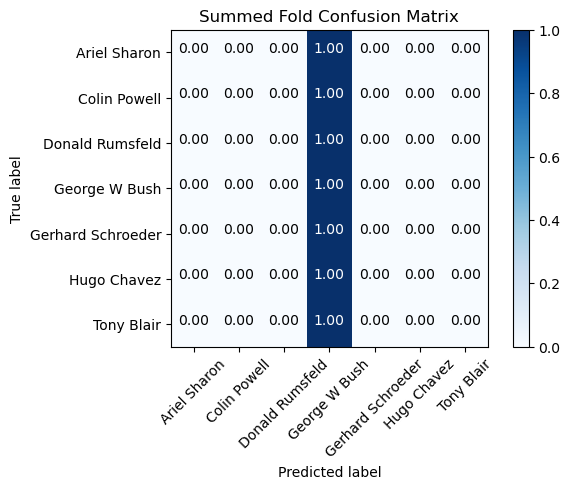

In [13]:
# Plot the summed confusion matrix
sum_conf_matrix = np.sum(conf_matrices, axis=0)
plt.figure()
plot_confusion_matrix(sum_conf_matrix, classes=target_names, normalize=True,
                      title='Summed Fold Confusion Matrix')

In [14]:
# Compute mean accuracy, precision, recall, f1-score
mean_accuracy = np.mean(fold_accs)
mean_precisions = np.mean(precisions)
mean_recalls = np.mean(recalls)
mean_f1_scores = np.mean(f1_scores)
print(f"Mean Accuracy: {mean_accuracy}")
print(f"Mean Precisions: {mean_precisions}")
print(f"Mean Recalls: {mean_recalls}")
print(f"Mean F1 Score: {mean_f1_scores}")


Mean Accuracy: 0.41149466037750243
Mean Precisions: 0.1693295123220228
Mean Recalls: 0.4114946705426357
Mean F1 Score: 0.23992820332800097


In [15]:
# Print precision, recall, f1-score, and confusion matrix for each fold
for i in range(num_folds):
    print(f"\nFold {i+1}:")
    print(f"Precision: {precisions[i]}")
    print(f"Recall: {recalls[i]}")
    print(f"F1-Score: {f1_scores[i]}")
    print("Confusion Matrix:")
    print(conf_matrices[i])


Fold 1:
Precision: 0.168799951925966
Recall: 0.4108527131782946
F1-Score: 0.23928784393900673
Confusion Matrix:
[[ 0  0  0  7  0  0  0]
 [ 0  0  0 24  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0 53  0  0  0]
 [ 0  0  0 11  0  0  0]
 [ 0  0  0  8  0  0  0]
 [ 0  0  0 14  0  0  0]]

Fold 2:
Precision: 0.168799951925966
Recall: 0.4108527131782946
F1-Score: 0.23928784393900673
Confusion Matrix:
[[ 0  0  0  8  0  0  0]
 [ 0  0  0 23  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0 53  0  0  0]
 [ 0  0  0 11  0  0  0]
 [ 0  0  0  7  0  0  0]
 [ 0  0  0 15  0  0  0]]

Fold 3:
Precision: 0.168799951925966
Recall: 0.4108527131782946
F1-Score: 0.23928784393900673
Confusion Matrix:
[[ 0  0  0  8  0  0  0]
 [ 0  0  0 23  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0 53  0  0  0]
 [ 0  0  0 11  0  0  0]
 [ 0  0  0  7  0  0  0]
 [ 0  0  0 15  0  0  0]]

Fold 4:
Precision: 0.168799951925966
Recall: 0.4108527131782946
F1-Score: 0.23928784393900673
Confusion Matrix:
[[ 0  0  0  8  0  0  0]
 [ 0  0  0 23  0 

In [16]:
# Compute mean and standard deviation of tpr
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

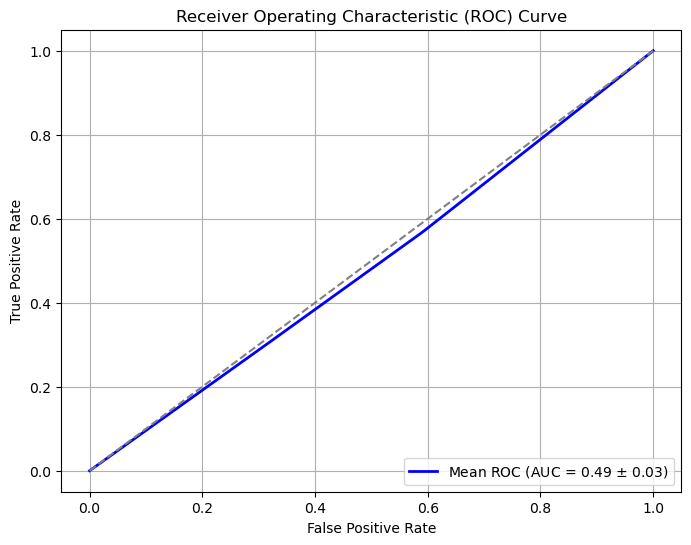

In [17]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()